In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import yfinance as yf
from typing import Tuple

#### VaR First Steps

Historical VaR (VaR = - Xth percentile of the historical distribution of portfolio returns)

In [3]:
def historical_var(returns: pd.DataFrame, weights : np.array, confidence_level: float) -> float:
    return np.percentile(returns @ weights, 100 - (confidence_level * 100))

Conditional VaR (CVaR = -(1/α) × ∫α₀ VaR(x)dx, where CVaR is the Conditional VaR, VaR is the VaR at confidence level α, and α₀ is the VaR confidence level)

In [4]:
def historical_Cvar(returns: pd.DataFrame, weights : np.array, confidence_level: float) -> float:
    portfolio_returns = returns @ weights
    belowVaR = portfolio_returns <= historical_var(returns, weights, confidence_level)
    return portfolio_returns[belowVaR].mean()

Test Portfolio

In [5]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
weights = np.array([0.25, 0.25, 0.25, 0.25])

data = yf.download(tickers, start='2022-01-01', end='2023-12-31')['Adj Close'] # 1 year

daily_returns = data.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed


In [6]:
hist_var = historical_var(daily_returns, weights, 0.95)
hist_var

-0.035500287125838324

In [7]:
hist_var * np.sqrt(10)

-0.11226176490760166

In [8]:
hist_cvar = historical_Cvar(daily_returns, weights, 0.95)
hist_cvar

-0.043121519311826846

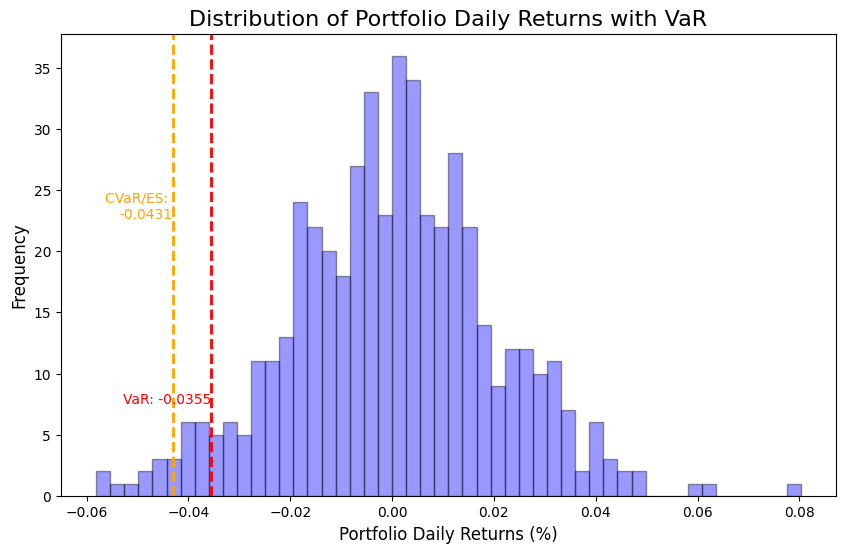

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(daily_returns @ weights, bins=50, color='blue', alpha=0.4, edgecolor='black')
plt.axvline(hist_var, color='red', linestyle='--', linewidth=2, label=f'VaR (5%): {hist_var:.4f}')
plt.text(hist_var, plt.gca().get_ylim()[1] * .2, f'VaR: {hist_var:.4f}', color='red', fontsize=10, ha='right')

plt.axvline(hist_cvar, color='orange', linestyle='--', linewidth=2, label=f'CVaR: {hist_cvar:.4f}')
plt.text(hist_cvar, plt.gca().get_ylim()[1] * 0.6, f'CVaR/ES: \n{hist_cvar:.4f}', color='orange', fontsize=10, ha='right')

plt.title("Distribution of Portfolio Daily Returns with VaR", fontsize=16)
plt.xlabel("Portfolio Daily Returns (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

#### Parametric VaR

In [11]:
def portfolio_performance(weights: np.ndarray, 
                          mean_returns: np.ndarray, 
                          cov: np.ndarray, 
                          Time: int) -> Tuple[float, float]:
    mean_w = np.sum(mean_returns*weights)*Time
    std_w = np.sqrt(weights.T @ cov @ weights) * np.sqrt(Time)
    return mean_w, std_w

In [12]:
def parametric_var(mean: np.ndarray, 
                    volatility: np.ndarray, 
                    confidence_level: float,
                    ppf: callable = ss.norm.ppf,) -> float:

    z_alpha = ppf(confidence_level) # не забывать предобработать std/volatility в соответсвии с dist

    return z_alpha * volatility - mean

In [13]:
mean_returns = daily_returns.mean()
cov_returns =  daily_returns.cov()
Time = 10

mean_w, std_w = portfolio_performance(weights, mean_returns,cov_returns, Time)

In [14]:
par_var = parametric_var(mean_w, std_w, 0.95)
par_var

0.10410260505983049

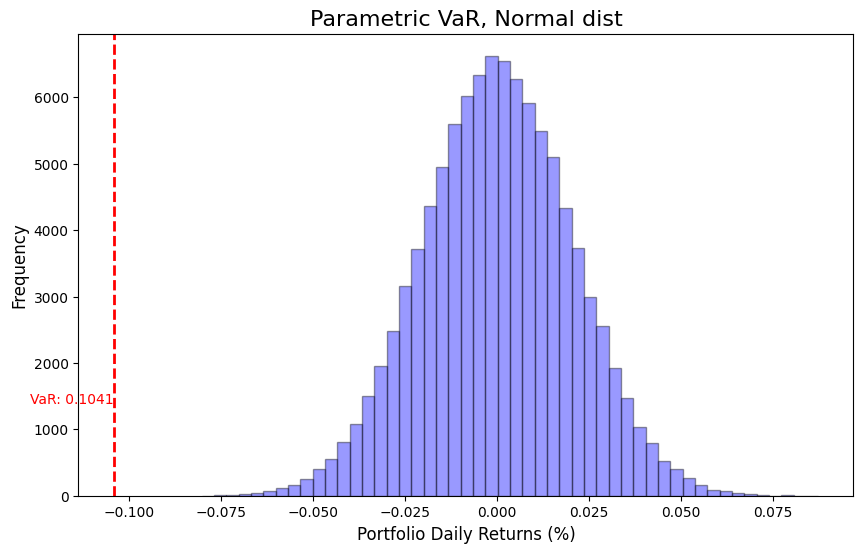

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(np.random.normal(loc=np.mean(daily_returns @ weights), scale=np.std(daily_returns @ weights), size=100000), bins=50, color='blue', alpha=0.4, edgecolor='black')
plt.axvline(-par_var, color='red', linestyle='--', linewidth=2, label=f'VaR (5%): {par_var:.4f}')
plt.text(-par_var, plt.gca().get_ylim()[1] * .2, f'VaR: {par_var:.4f}', color='red', fontsize=10, ha='right')

# plt.axvline(hist_cvar, color='orange', linestyle='--', linewidth=2, label=f'CVaR: {hist_cvar:.4f}')
# plt.text(hist_cvar, plt.gca().get_ylim()[1] * 0.6, f'CVaR/ES: \n{hist_cvar:.4f}', color='orange', fontsize=10, ha='right')

plt.title("Parametric VaR, Normal dist", fontsize=16)
plt.xlabel("Portfolio Daily Returns (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

#### Monte Carlo Portfolio Sim

In [16]:
# Monte Carlo Method
num_trails = 100000 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=mean_returns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, num_trails), fill_value=0.0)

initialPortfolio = 10000

for m in range (num_trails):
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(cov_returns)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

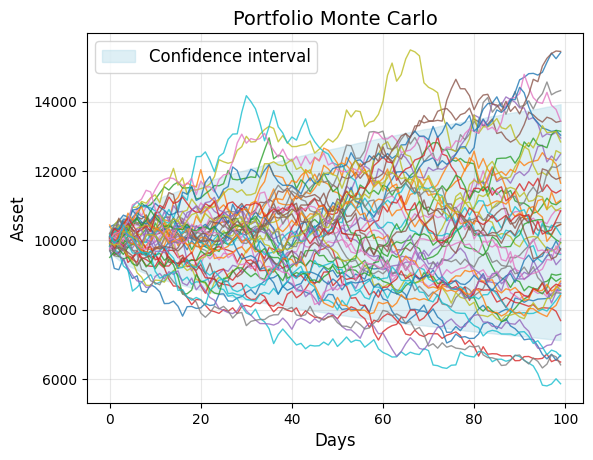

In [18]:
mean_simulation = portfolio_sims.mean(axis=1)
percentile_5 = np.percentile(portfolio_sims, 5, axis=1)
percentile_95 = np.percentile(portfolio_sims, 95, axis=1)

plt.fill_between(range(T), percentile_5, percentile_95, color="lightblue", alpha=0.4, label = "Confidence interval")

for i in range(50): 
    plt.plot(portfolio_sims[:, i], linewidth=1, alpha=0.8)

plt.title("Portfolio Monte Carlo", fontsize=14)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Asset", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

#### Outputs

In [19]:
# Извлекаем стоимость портфеля на 10-й день
portfolio_values_day_10 = portfolio_sims[9, :]  # 10-й день (индекс 9, так как индексация начинается с 0)

ten_day_returns = (portfolio_values_day_10 / initialPortfolio - 1)

#10-дневный VaR
ten_day_var = np.percentile(ten_day_returns, 5)

# Преобразуем в абсолютный VaR (в деньгах)
absolute_var = initialPortfolio * ten_day_var

print(f"10-дневный VaR: {ten_day_var} или {absolute_var}")

10-дневный VaR: -0.1004340261108177 или -1004.340261108177


In [20]:
print(f"10-дневный HistVaR: {hist_var*np.sqrt(10)} или {hist_var*initialPortfolio*np.sqrt(10)}")

10-дневный HistVaR: -0.11226176490760166 или -1122.6176490760167


In [21]:
print(f"10-дневный ParamVaR: {par_var} или {par_var*initialPortfolio}")

10-дневный ParamVaR: 0.10410260505983049 или 1041.026050598305


#### Play with interesting bibl

In [22]:
from fitter import Fitter

In [23]:
simulated_data = ss.norm.rvs(loc=10, scale = 10.5, size=10000)


f = Fitter(simulated_data)
f.fit()

2024-12-11 22:50:13.696 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-12-11 22:50:13.725 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.007653)
2024-12-11 22:50:13.742 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted betaprime distribution with error=0.059046)
2024-12-11 22:50:13.743 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=0.01817)
2024-12-11 22:50:13.749 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=0.034439)
2024-12-11 22:50:13.757 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.002669)
2024-12-11 22:50:13.766 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted beta distribution with error=0.000141)
2024-12-11 22:50:13.779 | INFO     | fitter.fitter:_fit_single_distribution:333

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
fatiguelife,0.000137,1122.897764,1144.528786,inf,0.006646,0.766362
nakagami,0.000137,1122.175855,1143.806876,inf,0.007343,0.650805
norminvgauss,0.000138,1124.385825,1153.227187,inf,0.007758,0.581203
tukeylambda,0.000138,1131.490022,1153.121043,inf,0.007161,0.681535
nct,0.000138,1122.395454,1151.236816,inf,0.007815,0.571807


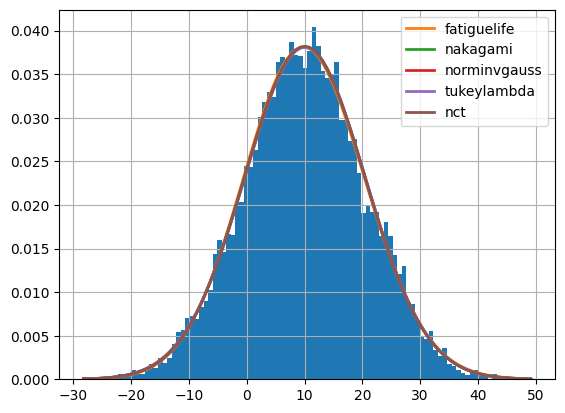

In [24]:
f.summary()

In [25]:
f.get_best()

{'fatiguelife': {'c': 0.01913348787021492,
  'loc': -536.866243231965,
  'scale': 546.8603626923623}}

((array([-3.81060943, -3.58545756, -3.46184782, ...,  3.46184782,
          3.58545756,  3.81060943]),
  array([-28.54477547, -28.4209187 , -25.98597995, ...,  45.09761756,
          47.94566833,  49.4637604 ])),
 (10.4672513567555, 10.08592667459271, 0.9999011646996866))

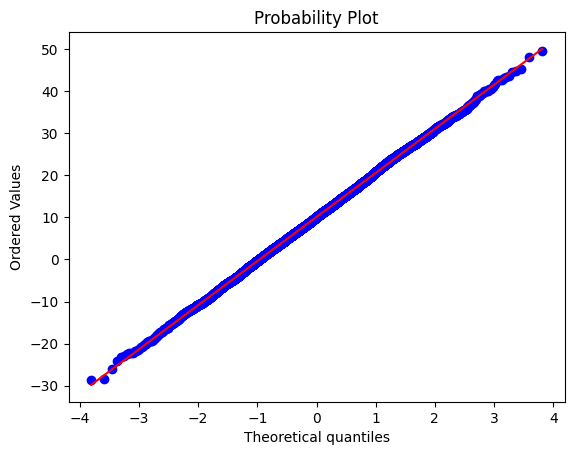

In [26]:
ss.probplot(simulated_data, dist="norm", plot=plt)

In [27]:
f = Fitter(daily_returns)
f.fit()

2024-12-11 22:51:13.006 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-12-11 22:51:13.019 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=5853.458917)
2024-12-11 22:51:13.040 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=468.01426)
2024-12-11 22:51:13.047 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=3251.385606)
2024-12-11 22:51:13.051 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=254.305331)
2024-12-11 22:51:13.060 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=4003.412164)
2024-12-11 22:51:13.076 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi distribution with error=4801.545659)
2024-12-11 22:51:13.078 | INFO     | fitter.fitter:_fit_single_distrib

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genhyperbolic,90.511315,-9.976697,18.027816,inf,0.010162,0.984685
norminvgauss,90.632646,-13.056164,9.347446,inf,0.008978,0.996633
johnsonsu,91.989579,-10.161830,12.241780,inf,0.009201,0.995301
dgamma,93.924035,-5.961950,10.840757,inf,0.014607,0.781188
dweibull,94.078732,-4.280285,12.522423,inf,0.015435,0.721235


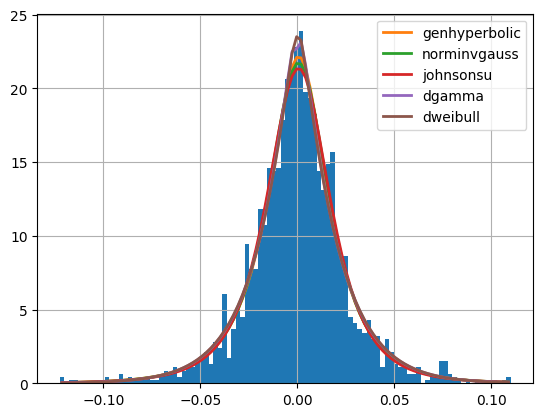

In [28]:
f.summary()

In [29]:
f.get_best()

{'genhyperbolic': {'p': 0.035928364409371694,
  'a': 0.6880750344495623,
  'b': -0.016443812234690814,
  'loc': 0.0008223472937621741,
  'scale': 0.016537156408590402}}

#### Real Archegos Stock Portfolio

In [49]:
test = yf.download('Para', start='2020-01-01', end='2021-12-31')
test

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PARA,PARA,PARA,PARA,PARA,PARA
Date,,,,,,
2020-01-02,36.654083,42.090000,42.349998,41.759998,42.209999,5738100
2020-01-03,36.096737,41.450001,41.759998,41.070000,41.730000,4640100
2020-01-06,36.627956,42.060001,42.070000,41.419998,41.490002,5700000
2020-01-07,36.688911,42.130001,42.180000,41.570000,41.880001,5104000
2020-01-08,36.462494,41.869999,42.369999,41.430000,42.200001,8139300
...,...,...,...,...,...,...
2021-12-23,28.350338,30.580000,30.690001,29.160000,29.309999,14137400
2021-12-27,27.923878,30.120001,30.580000,29.900000,30.530001,12801800


In [38]:
# Загрузка данных о компании ViacomCBS (тикер на момент 2020 года "VIAC")
ticker = yf.Ticker("PARA")

# Получение общего количества акций на конец 2020 года
shares_outstanding = ticker.info.get("sharesOutstanding")

# Проверка значения
print(f"Общее количество выпущенных акций ViacomCBS: {shares_outstanding}")

Общее количество выпущенных акций ViacomCBS: 626273024


In [39]:
ticker.info

{'address1': '1515 Broadway',
 'city': 'New York',
 'state': 'NY',
 'zip': '10036',
 'country': 'United States',
 'phone': '212 258 6000',
 'website': 'https://www.paramount.com',
 'industry': 'Entertainment',
 'industryKey': 'entertainment',
 'industryDisp': 'Entertainment',
 'sector': 'Communication Services',
 'sectorKey': 'communication-services',
 'sectorDisp': 'Communication Services',
 'longBusinessSummary': 'Paramount Global operates as a media, streaming, and entertainment company worldwide. It operates through TV Media, Direct-to-Consumer, and Filmed Entertainment segments. The TV Media segment operates CBS Television Network, a domestic broadcast television network; CBS Stations, a television station; and international free-to-air networks comprising Network 10, Channel 5, Telefe, and Chilevisión; domestic premium and basic cable networks, such as Paramount+ with Showtime, MTV, Comedy Central, Paramount Network, The Smithsonian Channel, Nickelodeon, BET Media Group, and CBS 

In [68]:
historical_data = yf.download("PARA", start="2020-02-03", end="2020-02-04")
print(historical_data)

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low   Open    Volume
Ticker           PARA       PARA       PARA       PARA   PARA      PARA
Date                                                                   
2020-02-03  28.807722  33.080002  33.869999  32.599998  33.73  11674300


In [89]:
tickers = ['PARA',
            # "WBD",
            # "GOTU",
            # "IQ",
            # "TME",
            # "VIPS",
            # "BIDU",
            # "FTCH",
            # "TCBI"
            ]

results = []

for ticker_symbol in tickers:
    historical_data = yf.download(ticker_symbol, start="2020-02-03", end="2020-02-04")
    
    if not historical_data.empty:
        closing_price =historical_data["Adj Close"].iloc[0][0]
        print()
        print(closing_price)
        print()
        
        ticker = yf.Ticker(ticker_symbol)
        info = ticker.info
        shares_outstanding = info.get("sharesOutstanding", None)
        
        print(f"Ticker: {ticker_symbol}")
        print(f"Shares Outstanding: {shares_outstanding}")
        print(f"Closing Price: {closing_price}")
        
        five_percent_shares = shares_outstanding * 0.05

        total_value = int(np.ceil(five_percent_shares * closing_price))
        print(total_value)
            
        results.append({
                "Ticker": ticker_symbol,
                "Shares Outstanding": shares_outstanding,
                "Closing Price (2020-02-03)": closing_price,
                "5% Shares": five_percent_shares,
                "Portfolio Value (5%)": total_value
            })


[*********************100%***********************]  1 of 1 completed
/var/folders/c0/1pbq54jd0ss0_3j6bcc3mfv00000gn/T/ipykernel_43301/3671859953.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closing_price =historical_data["Adj Close"].iloc[0][0]



28.807722091674805

Ticker: PARA
Shares Outstanding: 626273024
Closing Price: 28.807722091674805
902074962


In [90]:
df = pd.DataFrame(results)
df

,Ticker,Shares Outstanding,Closing Price (2020-02-03),5% Shares,Portfolio Value (5%)
0,PARA,626273024,28.807722,31313651.2,902074962
